# Checking Results of Probability Calibration

In [1]:
import deact_cal
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DoubleType, StringType

In [2]:
warehouse_location = 'hdfs://cerebro-namenode-vip.snc1/user/grp_gdoop_clv/grp_gdoop_clv_hiveDB.db'
python_location = './ANACONDA/anaconda2_env/bin/python'
archives_location = 'hdfs:////user/grp_gdoop_admin/anaconda/anaconda2_env.zip#ANACONDA'

spark = SparkSession\
	.builder\
	.master('yarn')\
	.appName('deact-calibration-accuracy-testing')\
	.config('spark.submit.deployMode','client')\
	.config('spark.executor.instances', 50)\
	.config('spark.yarn.appMasterEnv.PYSPARK_PYTHON',python_location)\
	.config('spark.yarn.dist.archives',archives_location)\
	.config('spark.sql.warehouse.dir',warehouse_location)\
	.config('spark.yarn.queue','public')\
	.enableHiveSupport()\
	.getOrCreate()
    
spark

# Run Pipeline with Calibration on Data from 1 Year Ago

In [3]:
train_date = '2017-11-12'
score_date = '2018-11-12'
train_pct = 0.1
calibrate_pct = 0.1
validate_pct = 0.1
calibrate_model = True
validate_model = True
score_active_users = True

In [4]:
# Coalescing some variables
calibrate_pct = calibrate_pct if calibrate_model else 0.
validate_pct = validate_pct if validate_model else 0.
score_date = score_date if score_active_users else 'N/A'
not_used_pct = 1 - train_pct - calibrate_pct - validate_pct

# Print workflow information
print('''[ {0} ] : BEGINNING DEACT MODEL PIPELINE

    PARAMETERS:
    Training date = {1}
    Proportion of training data used to:
        Train model = {2:0.0%}
        Calibrate model = {3:0.0%}
        Validate model = {4:0.0%}
        Not used = {5:0.0%}
    Scoring date = {6}
'''.format(datetime.utcnow(), train_date, train_pct, calibrate_pct, validate_pct, not_used_pct, score_date))

# Save locations
hdfs_loc = 'hdfs://cerebro-namenode-vip.snc1/user/grp_gdoop_clv/deact-model/'
eval_path = '/home/ceasterwood/Consumer-Intelligence/Models/Deact-Model/model_evaluation/'

# Run data pipeline
pl = deact_cal.Pipeline(spark, train_date, score_date, train_pct, calibrate_pct, validate_pct)
dfs = pl.run(calibrate_model, validate_model, score_active_users)

[ 2019-11-15 21:46:49.326849 ] : BEGINNING DEACT MODEL PIPELINE

    PARAMETERS:
    Training date = 2017-11-12
    Proportion of training data used to:
        Train model = 10%
        Calibrate model = 10%
        Validate model = 10%
        Not used = 70%
    Scoring date = 2018-11-12


DATA PIPELINE

[ 2019-11-15 21:46:49.327697 ] : Loading training feature data
[ 2019-11-15 21:46:54.561094 ] : Splitting training data into model training, calibration, and validation data
[ 2019-11-15 21:46:55.588529 ] : Creating feature engineering pipeline
[ 2019-11-15 21:50:10.928195 ] : Feature engineering model training data
[ 2019-11-15 21:50:12.127514 ] : Feature engineering model calibration data
[ 2019-11-15 21:50:13.173580 ] : Feature engineering model validation data
[ 2019-11-15 21:50:14.014263 ] : Loading scoring feature data
[ 2019-11-15 21:50:14.181507 ] : Feature engineering scoring data


In [6]:
model = deact_cal.Model(train_date, score_date, pl.feature_list)
model.train(dfs['training'])


MODELING

[ 2019-11-15 21:51:56.705828 ] : Training model
[ 2019-11-15 22:01:46.162802 ] : Zipping model feature importances


AttributeError: 'GBTClassificationModel' object has no attribute 'stages'

In [7]:
if calibrate_model:
    model.calibrate(dfs['calibration'])

[ 2019-11-15 22:04:31.494515 ] : Calibrating model

PREDICTING DEACTIVATIONS

[ 2019-11-15 22:04:31.494876 ] : Making predictions on calibration data


In [11]:
if validate_model:
    model.predict(dfs['validation'], 'validation', calibrate_model, save_results=False)
    evaluator = deact_cal.Evaluator(model.pred_df, calibrate_model, save_results=True, eval_path=eval_path)
    evaluator.class_metrics()
    evaluator.decision_boundary_curves()
    evaluator.calibration()
    evaluator.recency_aggregation()
    evaluator.feature_importances(model.feat_imp, min_imp=0.001)


PREDICTING DEACTIVATIONS

[ 2019-11-15 22:08:03.022899 ] : Making predictions on validation data

EVALUATING MODEL

[ 2019-11-15 22:08:03.214267 ] : Calculating confusion matrix for model predictions
[ 2019-11-15 22:09:32.312749 ] : Calculating model performance by class
[ 2019-11-15 22:09:32.319222 ] : Calculating points on PR and ROC curves
[ 2019-11-15 22:16:05.476954 ] : Calculating areas under PR and ROC curves
[ 2019-11-15 22:16:05.513259 ] : Plotting PR and ROC curves
[ 2019-11-15 22:16:05.951545 ] : Calculating probability calibration
[ 2019-11-15 22:18:23.628214 ] : Plotting calibration curve
[ 2019-11-15 22:18:23.837736 ] : Calculating aggregations by recency for model predictions
[ 2019-11-15 22:18:49.528733 ] : Plotting recency aggregations
[ 2019-11-15 22:18:50.686994 ] : Getting feature importances
[ 2019-11-15 22:18:50.690855 ] : Plotting feature importances


In [12]:
evaluator.confusion_df

,predicted_0,predicted_1,total
actual_0,788090,465288,1253378
actual_1,315425,1585686,1901111
total,1103515,2050974,3154489


In [13]:
evaluator.class_metrics_df

,N,precision,recall,f1,predOverActualN
0,1253378,0.714163,0.628773,0.668753,0.880433
1,1901111,0.773138,0.834084,0.802455,1.078829
weighted,3154489,0.749706,0.752507,0.749331,1.000000


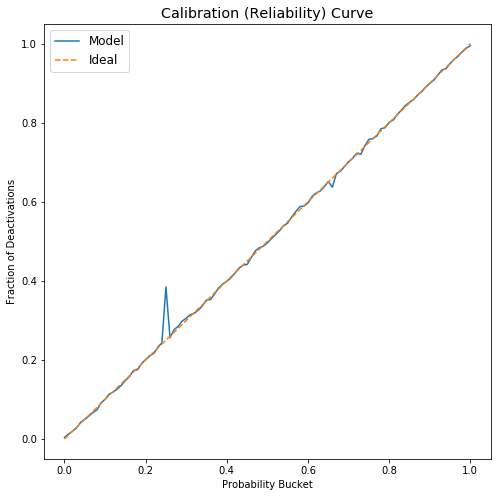

In [18]:
evaluator.plot_calibration

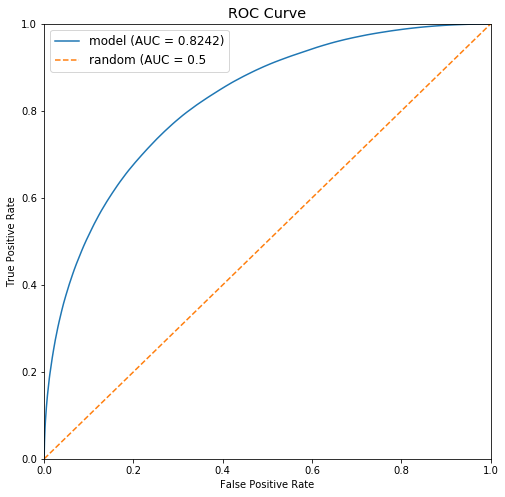

In [20]:
evaluator.plot_roc

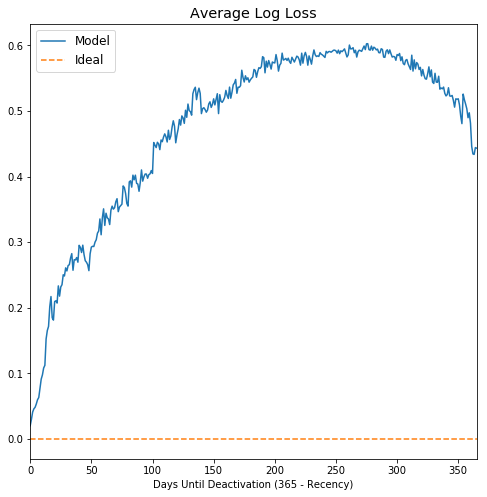

In [22]:
evaluator.plot_avg_log_loss

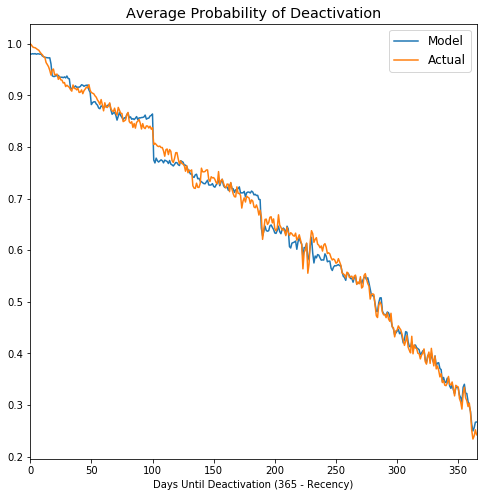

In [23]:
evaluator.plot_avg_prob_deact

In [27]:
if score_active_users:
    model.predict(dfs['scoring'], 'scoring', calibrate_model, save_results=True, hdfs_loc=hdfs_loc)
    model.total_deacts(calibrate_model, 'scoring', save_results=True, hdfs_loc=hdfs_loc)
    #_ = model.compare_to_prev_day(spark, calibrate_model, hdfs_loc, max_change=0.05)

print('\n[ {0} ] : COMPLETED DEACT MODEL PIPELINE\n'.format(datetime.utcnow()))


PREDICTING DEACTIVATIONS

[ 2019-11-15 22:38:48.920981 ] : Making predictions on scoring data
[ 2019-11-15 22:38:49.094592 ] : Saving scoring predictions to cerebro
[ 2019-11-15 22:44:46.526357 ] : Deact probabilities stored in hdfs://cerebro-namenode-vip.snc1/user/grp_gdoop_clv/deact-model/ce_keep_deact_predictions/record_date=2018-11-12
[ 2019-11-15 22:44:46.526617 ] : Calculating total deactivations by day for scoring data
[ 2019-11-15 22:44:46.667440 ] : Saving total deactivations for scoring data to cerebro
[ 2019-11-15 22:47:18.675741 ] : Deact probabilities stored in hdfs://cerebro-namenode-vip.snc1/user/grp_gdoop_clv/deact-model/ce_keep_deact_totals/record_date=2018-11-12

[ 2019-11-15 22:47:18.676132 ] : COMPLETED DEACT MODEL PIPELINE



# Compare Results for V2, V3, and V3 Calibrated Models

In [29]:
df_raw = spark.read.orc('hdfs://cerebro-namenode-vip.snc1/user/grp_gdoop_clv/deact-model/ce_keep_deact_predictions/record_date='+score_date)
df_raw.show(10)

+--------------------+---------+-------------------+-------------------+
|         consumer_id|recency_x|         prob_deact|     prob_deact_cal|
+--------------------+---------+-------------------+-------------------+
|00002420-3a76-11e...|       37| 0.1110834194843815|0.09480646741793239|
|00003906-2173-11e...|      218| 0.6527547498435193|  0.641213779380674|
|00003f0c-f241-11e...|      350| 0.9387449949718456| 0.9760392085677981|
|000047c8-27ee-11e...|       20|0.16712432435845959| 0.1742020031826266|
|000047f0-e5c3-11e...|      149| 0.7195289344863843| 0.7023434198979426|
|00005426-09dd-11e...|       58|0.36648049982257025|  0.365605331358756|
|00007000-2855-11e...|      204|  0.904931224667398| 0.9342625729892635|
|0000b3e0-d17e-11e...|      352| 0.9487553592136257| 0.9910001124985938|
|0000db44-f2aa-11e...|      204|0.48869199984470046| 0.4983912080564958|
|0000ddc0-95ee-11e...|      142|0.17007622315481197| 0.1742020031826266|
+--------------------+---------+-------------------

In [30]:
df_target = spark.sql('from grp_gdoop_clv_db.ce_keep_deact_target') \
    .filter(F.col('record_date') == score_date) \
    .select('consumer_id', 'deactivated')
df_target.show(10)

+--------------------+-----------+
|         consumer_id|deactivated|
+--------------------+-----------+
|00001d30-d8b0-11e...|          1|
|00009cd2-1268-11e...|          1|
|0000a2a6-28a5-11e...|          1|
|000107a4-17d5-11e...|          1|
|000127f0-d311-11e...|          1|
|000181b0-e037-11e...|          1|
|0001843e-24d9-11e...|          0|
|0001af4e-26e7-11e...|          0|
|0001c950-d152-11e...|          1|
|0001f0e6-25f5-11e...|          0|
+--------------------+-----------+
only showing top 10 rows



In [32]:
df_raw_old = spark.sql('from grp_gdoop_clv_db.eb_deact_predictions1') \
    .filter(F.col('ds') == score_date) \
    .withColumnRenamed('prob_deact', 'prob_deact_v2') \
    .select('consumer_id', 'prob_deact_v2')
#    .withColumn('recency_x', F.datediff(F.col('deact_date'), F.col('ds'))) \
df_raw_old.show(10)

+--------------------+-------------+
|         consumer_id|prob_deact_v2|
+--------------------+-------------+
|00004c70-04c8-11e...|   0.93539953|
|00004cbe-2884-11e...|   0.27800018|
|00007f6c-6f2e-11e...|   0.36988002|
|00029f22-1480-11e...|   0.35909104|
|0002dbf0-57b3-11e...|   0.78260374|
|00040560-29ae-11e...|   0.36371344|
|00053d50-b468-11e...|   0.86492455|
|00054120-d336-11e...|   0.17081839|
|0005937e-1c75-11e...|   0.74335515|
|0005b3b6-a886-11e...|    0.5759954|
+--------------------+-------------+
only showing top 10 rows



In [37]:
final = df_raw \
    .join(df_raw_old, df_raw.consumer_id == df_raw_old.consumer_id, how='left') \
    .drop(df_raw_old.consumer_id) \
    .join(df_target, df_raw.consumer_id == df_target.consumer_id) \
    .drop(df_target.consumer_id) \
    .cache()

final.show(10)

+--------------------+---------+------------------+-------------------+-----------+-------------+
|         consumer_id|recency_x|        prob_deact|     prob_deact_cal|deactivated|prob_deact_v2|
+--------------------+---------+------------------+-------------------+-----------+-------------+
|0000303c-26f7-11e...|       30|0.3707008094436849|0.36670599471880444|          0|     0.446674|
|000056e4-8848-11e...|      225|0.7186079197272879| 0.7023434198979426|          1|    0.6105505|
|00007f18-39aa-11e...|      322| 0.894135564243669| 0.9137918854640074|          1|   0.90832436|
|0000c2d4-26ea-11e...|      339|0.9233687571181955| 0.9500435436624178|          1|   0.96314824|
|000137d0-d082-11e...|      118|0.8181413793418156| 0.8182760479290186|          1|    0.7988359|
|00026b40-b4ce-11e...|      139|0.7246990418823425|  0.710236220472441|          1|    0.6367702|
|00029680-f49a-11e...|       18|0.1571730852840627|0.16191412651589643|          1|   0.19496708|
|00029750-c4fc-11e..

In [39]:
final.write \
    .mode('overwrite') \
    .format('orc') \
    .option('orc.compress', 'snappy') \
    .save('hdfs://cerebro-namenode-vip.snc1/user/grp_gdoop_clv/deact-model/ce_keep_deact_accuracy_test/record_date='+score_date)

# Compare Log Loss & Total Deacts

### Overall

V3 calibrated < V3 < V2 --> V3 calibrated does best overall

In [40]:
# Log Loss
final \
    .withColumn('log_loss_v2', F.when(F.col('deactivated') == 1, -F.log(F.col('prob_deact_v2')))
        .otherwise(-F.log(F.lit(1.0) - F.col('prob_deact_v2')))) \
    .withColumn('log_loss_v3', F.when(F.col('deactivated') == 1, -F.log(F.col('prob_deact')))
        .otherwise(-F.log(F.lit(1.0) - F.col('prob_deact')))) \
    .withColumn('log_loss_v3_cal', F.when(F.col('deactivated') == 1, -F.log(F.col('prob_deact_cal')))
        .otherwise(-F.log(F.lit(1.0) - F.col('prob_deact_cal')))) \
    .agg(
        F.avg('log_loss_v2').alias('avg_log_loss_v2'),
        F.avg('log_loss_v3').alias('avg_log_loss_v3'),
        F.avg('log_loss_v3_cal').alias('avg_log_loss_v3_calibrated'),
        ) \
    .show()

+------------------+------------------+--------------------------+
|   avg_log_loss_v2|   avg_log_loss_v3|avg_log_loss_v3_calibrated|
+------------------+------------------+--------------------------+
|0.5037470163579497|0.4932564593807718|       0.49141057909471686|
+------------------+------------------+--------------------------+



V3 < V3 calibrated < V2 --> V3 without calibration does best overall, however the problem is it does poorly on the customers deactivating soonest, hence the need for calibration

In [41]:
# Total Deacts
final \
    .agg(
        F.sum(F.col('deactivated')).alias('deacts_actual'),
        F.sum(F.col('prob_deact_v2')).alias('deacts_pred_v2'),
        F.sum(F.col('prob_deact')).alias('deacts_pred_v3'),
        F.sum(F.col('prob_deact_cal')).alias('deacts_pred_v3_cal'),
    ) \
    .withColumn('pred_over_actual_v2', F.col('deacts_pred_v2') / F.col('deacts_actual') - F.lit(1.)) \
    .withColumn('pred_over_actual_v3', F.col('deacts_pred_v3') / F.col('deacts_actual') - F.lit(1.)) \
    .withColumn('pred_over_actual_v3_cal', F.col('deacts_pred_v3_cal') / F.col('deacts_actual') - F.lit(1.)) \
    .select('pred_over_actual_v2', 'pred_over_actual_v3', 'pred_over_actual_v3_cal') \
    .show()

+-------------------+-------------------+-----------------------+
|pred_over_actual_v2|pred_over_actual_v3|pred_over_actual_v3_cal|
+-------------------+-------------------+-----------------------+
|0.03961045235866312|0.01213587409584238|   0.020495354626334894|
+-------------------+-------------------+-----------------------+



### By Recency

In [42]:
# Recency bucket UDF
def bucket(days_until_deact):
    if days_until_deact <= 30:
        return '1. 1-30 days'
    elif days_until_deact <= 60:
        return '2. 31-60 days'
    elif days_until_deact <= 90:
        return '3. 61-90 days'
    elif days_until_deact <= 120:
        return '4. 91-120 days'
    elif days_until_deact <= 180:
        return '5. 121-180 days'
    else:
        return '6. 181-365 days'

udf_bucket = F.udf(bucket)

In [44]:
# Log Loss
logloss = final \
    .filter((F.col('recency_x') >= 0) & (F.col('recency_x') <= 364)) \
    .withColumn('days_until_deact', F.lit(365) - F.col('recency_x')) \
    .withColumn('days_until_deact_bucket', udf_bucket(F.col('days_until_deact'))) \
    .withColumn('log_loss_v2', F.when(F.col('deactivated') == 1, -F.log(F.col('prob_deact_v2')))
        .otherwise(-F.log(F.lit(1.0) - F.col('prob_deact_v2')))) \
    .withColumn('log_loss_v3', F.when(F.col('deactivated') == 1, -F.log(F.col('prob_deact')))
        .otherwise(-F.log(F.lit(1.0) - F.col('prob_deact')))) \
    .withColumn('log_loss_v3_cal', F.when(F.col('deactivated') == 1, -F.log(F.col('prob_deact_cal')))
        .otherwise(-F.log(F.lit(1.0) - F.col('prob_deact_cal')))) \
    .groupBy(F.col('days_until_deact_bucket')) \
    .agg(
        F.avg(F.col('log_loss_v2')).alias('avg_log_loss_v2'),
        F.avg(F.col('log_loss_v3')).alias('avg_log_loss_v3'),
        F.avg(F.col('log_loss_v3_cal')).alias('avg_log_loss_v3_cal'),
    ) \
    .toPandas() \
    .sort_values('days_until_deact_bucket') \
    .reset_index(drop=True)

logloss

,days_until_deact_bucket,avg_log_loss_v2,avg_log_loss_v3,avg_log_loss_v3_cal
0,1. 1-30 days,0.179995,0.189087,0.179088
1,2. 31-60 days,0.303132,0.301833,0.298612
2,3. 61-90 days,0.374185,0.373643,0.372097
3,4. 91-120 days,0.445859,0.445166,0.444603
4,5. 121-180 days,0.510006,0.506450,0.505198
5,6. 181-365 days,0.582361,0.563418,0.562467


V3 outperforms V2 in all recency buckets EXCEPT 1-30 days, where it does worse. Adding the calibration to V3 means it does better than V2 in all buckets.

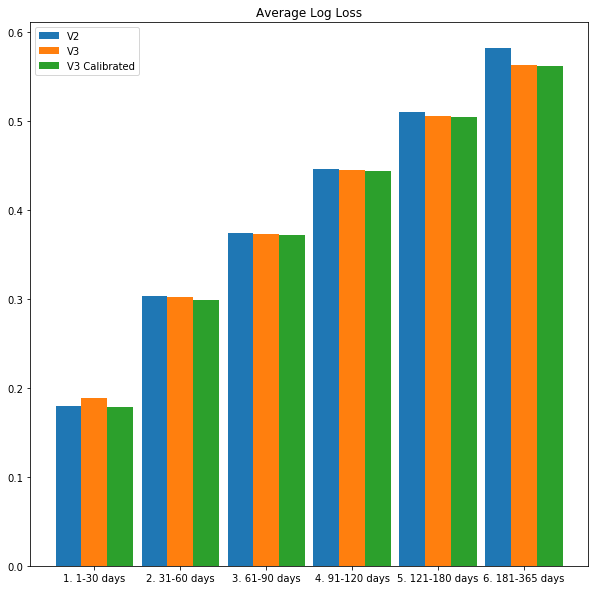

In [45]:
fig = plt.figure(figsize=(10,10))
width = 0.3
plt.bar([x - width for x in range(6)], logloss.avg_log_loss_v2, width, label='V2')
plt.bar([x for x in range(6)], logloss.avg_log_loss_v3, width, label='V3')
plt.bar([x + width for x in range(6)], logloss.avg_log_loss_v3_cal, width, label='V3 Calibrated')
plt.title('Average Log Loss')
plt.xticks(range(6), logloss.days_until_deact_bucket)
plt.legend()

fig

In [46]:
total_deacts = final \
    .filter((F.col('recency_x') >= 0) & (F.col('recency_x') <= 364)) \
    .withColumn('days_until_deact', F.lit(365) - F.col('recency_x')) \
    .withColumn('days_until_deact_bucket', udf_bucket(F.col('days_until_deact'))) \
    .groupBy(F.col('days_until_deact_bucket')) \
    .agg(
        F.sum(F.col('deactivated')).alias('deacts_actual'),
        F.sum(F.col('prob_deact_v2')).alias('deacts_pred_v2'),
        F.sum(F.col('prob_deact')).alias('deacts_pred_v3'),
        F.sum(F.col('prob_deact_cal')).alias('deacts_pred_v3_cal'),
    ) \
    .withColumn('pred_over_actual_v2', F.col('deacts_pred_v2') / F.col('deacts_actual') - F.lit(1.)) \
    .withColumn('pred_over_actual_v3', F.col('deacts_pred_v3') / F.col('deacts_actual') - F.lit(1.)) \
    .withColumn('pred_over_actual_v3_cal', F.col('deacts_pred_v3_cal') / F.col('deacts_actual') - F.lit(1.)) \
    .select('days_until_deact_bucket', 'pred_over_actual_v2', 'pred_over_actual_v3', 'pred_over_actual_v3_cal') \
    .toPandas() \
    .sort_values('days_until_deact_bucket') \
    .reset_index(drop=True)

total_deacts

,days_until_deact_bucket,pred_over_actual_v2,pred_over_actual_v3,pred_over_actual_v3_cal
0,1. 1-30 days,0.003588,-0.025358,0.010045
1,2. 31-60 days,0.008363,-0.009668,0.013699
2,3. 61-90 days,0.012452,0.011576,0.029359
3,4. 91-120 days,0.015509,0.004438,0.013661
4,5. 121-180 days,0.005191,0.001960,0.003997
5,6. 181-365 days,0.075262,0.030203,0.030281


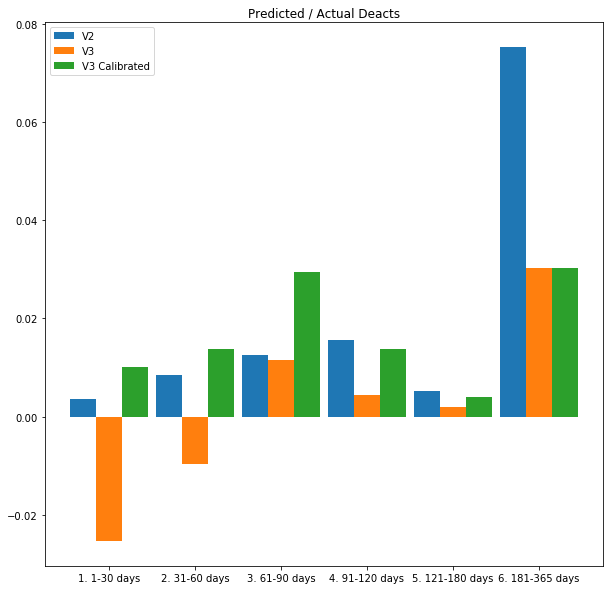

In [47]:
fig = plt.figure(figsize=(10,10))
width = 0.3
plt.bar([x - width for x in range(6)], total_deacts.pred_over_actual_v2, width, label='V2')
plt.bar([x for x in range(6)], total_deacts.pred_over_actual_v3, width, label='V3')
plt.bar([x + width for x in range(6)], total_deacts.pred_over_actual_v3_cal, width, label='V3 Calibrated')
plt.title('Predicted / Actual Deacts')
plt.xticks(range(6), total_deacts.days_until_deact_bucket)
plt.legend()

fig